In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import numpy as np
from math import floor
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm

## LOAD DATA

In [10]:
# 1. Загрузка и подготовка данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## MODEL

In [2]:
# 2. Создание модели
class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 10)

    def forward(self, x):
        return self.resnet(x)

## TRAIN

In [13]:
# 3. Обучение модели
def train_model(model, train_loader, criterion, optimizer, num_epochs=10, device = 'cpu'):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

In [14]:
model = ResNetModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.resnet.fc.parameters(), lr=0.001)

In [15]:
train_model(model, train_loader, criterion, optimizer, num_epochs=5)

  1%|          | 7/782 [00:10<20:04,  1.55s/it]


KeyboardInterrupt: 

In [6]:




# 4. Сохранение и загрузка чекпоинта модели
torch.save(model.state_dict(), 'model_resnet.pth')
model_loaded = ResNetModel()
model_loaded.load_state_dict(torch.load('model_resnet.pth'))
model_loaded.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/igoreshka/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 11.6MB/s]


KeyboardInterrupt: 

In [4]:
# FGSM attack code
def fgsm_attack(img, eps, data_grad):
    perturbed_img = img + eps*data_grad.sign() # Perturbing image by epsilon shift along element-wise sign of the data gradient
    perturbed_img = torch.clamp(perturbed_img, 0, 1) # As MNIST data must be in [0,1]

    return perturbed_img

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNetModel()
pretrained_model = "./data/lenet_mnist_model.pth"
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

model.to(device)

model.eval()

FileNotFoundError: [Errno 2] No such file or directory: './data/lenet_mnist_model.pth'

In [55]:
def test( model, test_loader, eps ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    for data, target in test_loader:
        data.requires_grad = True # Set flag to enable computation of data_grad
        output = model(data)  # Forward pass 
        init_pred = output.max(1, keepdim=True)[1] # get the initial prediction

        if init_pred.item() != target.item():  # Only bother to attck if initial prediction is correct
            continue
        
        loss = F.nll_loss(output, target) # Calculate the negative log likelihood loss
        
        model.zero_grad() # Zero all existing gradients (prevents accumulation of gradient like in RNNs)
        loss.backward() # Calculate gradients in backward pass
       
        data_grad = data.grad.data  # data_grad
        perturbed_data = fgsm_attack(data, eps, data_grad) # FGSM Attack
        
        output = model(perturbed_data) # Re-classify the perturbed image

        final_pred = output.max(1, keepdim=True)[1] # get the new prediction
        
        if final_pred.item() == target.item(): # Check for success
            correct += 1
            
            if (eps == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:    
            # Saving adversarial examples
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(eps, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial examples
    return final_acc, adv_examples


In [56]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


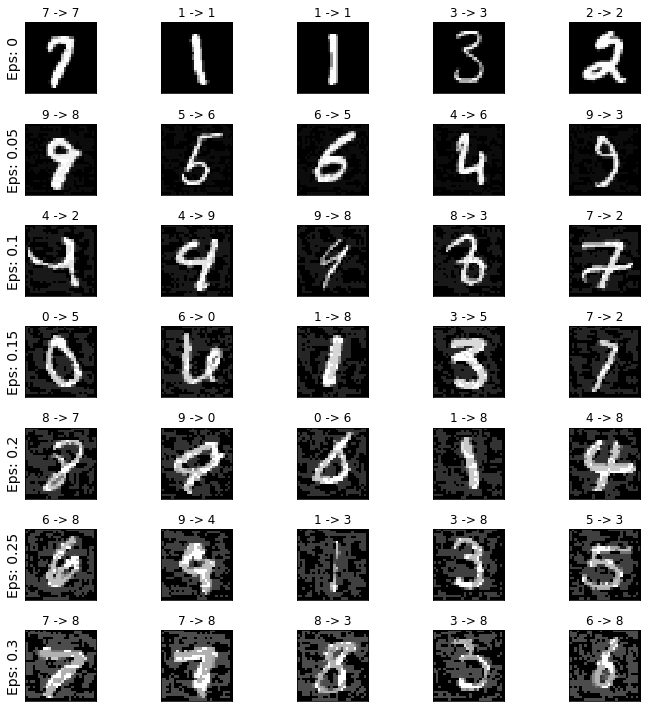

In [60]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(10,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Accuracy')

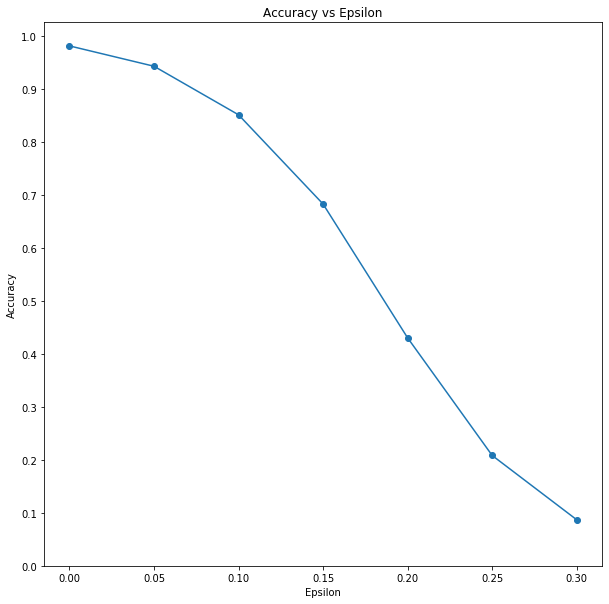

In [64]:
plt.figure(figsize=(10,10))
plt.plot(epsilons, accuracies,'-o')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")